# differences between putative inhibitory and pyramidal neurons

mainly focusing on differences in STRFs and Tuning Curves


In [49]:
import pandas as pd
from joblib import Memory, dump, Parallel, delayed
import pathlib as pl
from src.root_path import root_path
from src.visualization.fancy_plots import subplots_sqr
from configparser import ConfigParser
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from nems_lbhb.baphy_experiment import BAPHYExperiment
from nems_lbhb.celldb import get_single_cell_data, update_single_cell_data
from nems_lbhb.strf.strf import tor_tuning
from nems_lbhb.strf.torc_subfunctions import strfplot, interpft
import nems.db as nd

from IPython.display import display

In [18]:
config = ConfigParser()
config.read_file(open(root_path / 'config/settings.ini'))


In [19]:
runclass='TOR'
sql="SELECT sCellFile.*,gSingleCell.siteid,gSingleCell.phototag FROM gSingleCell " +\
    "INNER JOIN sCellFile ON gSingleCell.id=sCellFile.singleid " +\
    "INNER JOIN gRunClass on gRunClass.id=sCellFile.runclassid " +\
   f"WHERE gRunClass.name='{runclass}' AND not(isnull(phototag))"
d=nd.pd_query(sql)
d['parmfile']=d['stimpath']+d['stimfile']

In [20]:
print('there are multiple torc for a given neuron what to do?')
site_df = d.loc[:, ['siteid', 'parmfile']].drop_duplicates()
display(site_df.head(5))
tag_df = d.loc[d.phototag.isin(['a', 's']), ['cellid', 'phototag', 'siteid']].drop_duplicates()

there are multiple torc for a given neuron what to do?


,siteid,parmfile
0,TNC018a,/auto/data/daq/Teonancatl/TNC018/TNC018a10_p_T...
3,TNC022a,/auto/data/daq/Teonancatl/TNC022/TNC022a09_p_T...
46,TNC017a,/auto/data/daq/Teonancatl/TNC017/TNC017a09_p_T...
112,TNC017a,/auto/data/daq/Teonancatl/TNC017/TNC017a07_p_T...
178,TNC018a,/auto/data/daq/Teonancatl/TNC018/TNC018a07_p_T...


calculates and caches STRF and extra data

In [21]:
memory = Memory(str(pl.Path(config['paths']['analysis_cache']) / 'STRF'))

In [120]:
tor_tuning_cached = memory.cache(tor_tuning)

all_strfs_raw = list()

strf_df = pd.DataFrame()

for _, row in site_df.iterrows():

    expt = BAPHYExperiment(parmfile=row.parmfile)
    options = {'recache':False, 'resp': True, 'rasterfs': 1000, 'stim':False}
    rec = expt.generate_recording(**options)
    cellids = rec['resp'].chans

    cellids = [c for c in cellids if c in tag_df.cellid.unique()]
    
    def neu_strf_2_dict(cellid, rec):
        strf = tor_tuning_cached(cellid=cellid, rec=rec)
        df = dict()
        df['cellid'] = cellid
        # unpacks named tuple to dictionary, if a field is a dictionaly further unpacks the key,vals
        for field in strf._fields:
            attr = getattr(strf, field)
            if isinstance(attr, dict):
                df.update(attr)
            else:
                df[field] = attr
        return df

    dfs = Parallel(n_jobs=4)(
                           delayed(neu_strf_2_dict)(neuron, rec=rec)
                           for neuron in cellids)


    dfs = pd.DataFrame(dfs)
    dfs['parmfile'] = row.parmfile

    strf_df = strf_df.append(dfs, ignore_index=True)


strf_df = pd.merge(strf_df, tag_df.loc[:,('cellid', 'phototag')], how='left', on='cellid', validate="m:1")

[nems_lbhb.baphy_io INFO] Loading /auto/data/daq/Teonancatl/TNC018/TNC018a10_p_TOR.m
[nems_lbhb.baphy_io INFO] evp file for licks: /auto/data/daq/Teonancatl/TNC018/TNC018a10_p_TOR.evp
[nems_lbhb.baphy_io INFO] Loading /auto/data/daq/Teonancatl/TNC018/TNC018a10_p_TOR.m
[nems_lbhb.baphy_io INFO] evp file for licks: /auto/data/daq/Teonancatl/TNC018/TNC018a10_p_TOR.evp
[nems_lbhb.baphy_experiment INFO] Remove post-response events
[nems_lbhb.baphy_experiment INFO] Removing post-reponse data
[nems_lbhb.baphy_io INFO] rounding Trial offset spike times to even number of rasterfs bins
[nems_lbhb.baphy_io INFO] 60 trials totaling 196.15 sec
[nems_lbhb.baphy_io INFO] Loading /auto/data/daq/Teonancatl/TNC018/TNC018a10_p_TOR.m
[nems_lbhb.baphy_io INFO] evp file for licks: /auto/data/daq/Teonancatl/TNC018/TNC018a10_p_TOR.evp
[nems_lbhb.baphy_experiment INFO] Creating trial epochs
[nems_lbhb.baphy_experiment INFO] Creating stim epochs
[nems_lbhb.baphy_experiment INFO] Creating Light epochs
[nems_lbhb

In [156]:
DF = strf_df.sort_values(by=['cellid', 'Signal_to_Noise'], ascending=[True, False]
                 ).drop_duplicates(subset=['cellid']).reset_index(drop=True)


# Organize data in arrays with dim0 = Neuron.

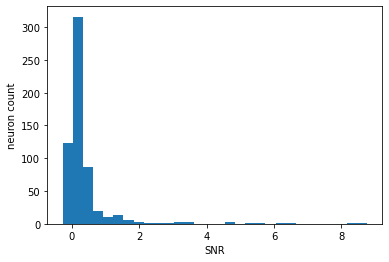

In [157]:
fig, ax  = plt.subplots()
_ = ax.hist(DF['Signal_to_Noise'], bins=30)
_ = ax.set_xlabel('SNR')
_ = ax.set_ylabel('neuron count')
plt.show()

## Smooths STRFs

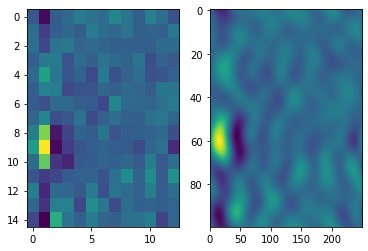

In [160]:
def smooth_strf(strf):
    itp_freq, itp_time = 100, 250
    return  interpft(interpft(strf, itp_freq, 0), itp_time, 1)

DF['STRF_smooth'] = DF['STRF'].apply(smooth_strf)
toplot = DF.loc[DF.Signal_to_Noise.idxmax(),:]
fig, axes = plt.subplots(1,2)
axes[0].imshow(toplot.STRF, aspect='auto')
axes[1].imshow(toplot.STRF_smooth, aspect='auto')
plt.show()


## STRFs
selected by SNR and discriminates by tag

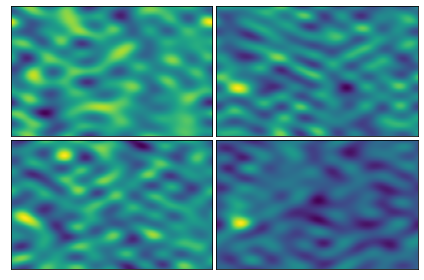

In [177]:
# defines extra ploting parameters and snr sorted STRF ploting

def plot_STRF(Series, ax=None, **kwargs):
    if ax == None:
        fig, ax = plt.subplots()
    arr = Series['STRF_smooth']
    tlen = Series['basep']
    noct = Series['octaves']
    extent = [0, tlen, 0, noct]
    _ = ax.imshow(arr, aspect='auto', extent=extent, origin='lower', **kwargs)
    return arr

def STRF_tiling(DF, sharemap=False, **kwargs):

    fig, axes = subplots_sqr(len(DF), sharey=True, sharex=True, **kwargs)
    axes= np.ravel(axes)

    vmin, vmax = np.stack(DF['STRF_smooth'].values).min(), np.stack(DF['STRF_smooth'].values).max()

    for ax, (_, series) in zip(axes, DF.iterrows()):
        if sharemap:
            _ = plot_STRF(series, ax=ax, vmin=vmin, vmax=vmax)
        else:
            _ = plot_STRF(series, ax=ax)

    for ax in axes:
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

    fig.tight_layout(h_pad= 0.01, w_pad=0.01)
    return fig, axes

### inhibitory interneurons

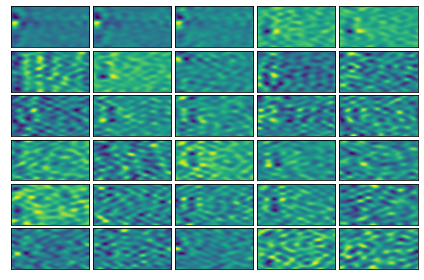

In [178]:
ff_snr = DF.Signal_to_Noise > 0.2
ff_act = DF.phototag == 'a'

toplot = DF.loc[ff_snr & ff_act, :].sort_values(by='Signal_to_Noise', ascending=False)
fig, axes = STRF_tiling(toplot, sharemap=False)

### pyramidal neurons

plotting 25 of 221


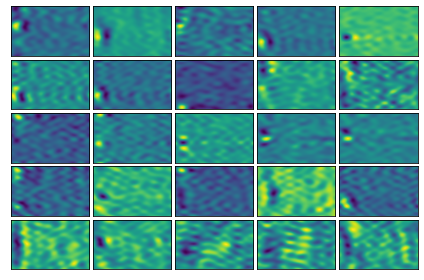

In [180]:
ff_snr = DF.Signal_to_Noise > 0.2
ff_sup = DF.phototag == 's'
limit = 25

toplot = DF.loc[ff_snr & ff_sup, :].sort_values(by='Signal_to_Noise', ascending=False)
print(f'plotting {limit} of {len(toplot)}')
fig, axes = STRF_tiling(toplot.head(limit), sharemap=False)

## STRF component
across all neurons

In [68]:
def plot_components_with_mean(time_comps, freq_comps, **kwargs):

    def plot_with_mean(tser, ax, **kwargs):
        _ = ax.plot(tser.T, alpha=0.1, color='gray', **kwargs)
        _ = ax.plot(np.nanmean(tser, axis=0), alpha=1, color='black', **kwargs)
        return ax

    fig, (time_ax, freq_ax)  = plt.subplots(1,2)

    _ = plot_with_mean(time_comps, time_ax, **kwargs)
    _ = plot_with_mean(freq_comps, freq_ax, **kwargs)

    time_ax.set_title('temporal components')
    freq_ax.set_title('frequency components')

    return fig, [time_ax, freq_ax]


### raw components

In [183]:
# calculates temporal and frequency top components
smooth_strfs = np.stack(DF['STRF_smooth'].values)
Nd, itp_freq, itp_time = smooth_strfs.shape


time_comp = np.empty((Nd, itp_time))
freq_comp = np.empty((Nd, itp_freq))
for ii, strf in enumerate(smooth_strfs):
    [u, s, v] = np.linalg.svd(strf)
    time_comp[ii,:] = v[0, :]
    freq_comp[ii,:] = u[:, 0]

# flip components to match orientation
time_flip_mask = np.abs(np.min(time_comp, axis=1)) > np.max(time_comp, axis=1)
time_comp[time_flip_mask] = time_comp[time_flip_mask] * -1

freq_flip_mask = np.abs(np.min(freq_comp, axis=1)) > np.max(freq_comp, axis=1)
freq_comp[freq_flip_mask] = freq_comp[freq_flip_mask] * -1

Text(0.5, 0.98, 'raw STRF components')

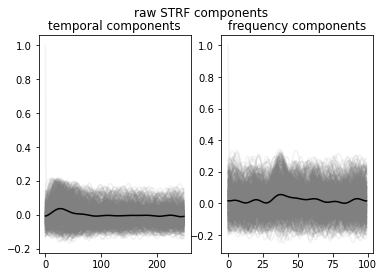

In [184]:
fig, axes = plot_components_with_mean(time_comp, freq_comp)
fig.suptitle('raw STRF components')

### centered components

In [185]:
# center components at maximum
# temporal component
# time_comp0 = np.full((Nd, itp_time*2), np.nan)
time_comp0 = np.zeros((Nd, itp_time*2))
for ii, tc in enumerate(time_comp):
    start = int(itp_time - np.argmax(tc))
    end = int(start + itp_time)
    time_comp0[ii, start:end] = tc

# frequency component
# freq_comp0 = np.full((Nd, itp_freq*2), np.nan)
freq_comp0 = np.zeros((Nd, itp_freq*2))
for ii, fc in enumerate(freq_comp):
    start = int(itp_freq - np.argmax(fc))
    end = int(start + itp_freq)
    freq_comp0[ii, start:end] = fc

Text(0.5, 0.98, 'centered STRF components')

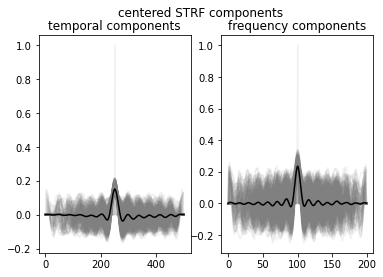

In [186]:
fig, axes = plot_components_with_mean(time_comp0, freq_comp0)
fig.suptitle('centered STRF components')

### components filtered by SNR and discriminated by tag

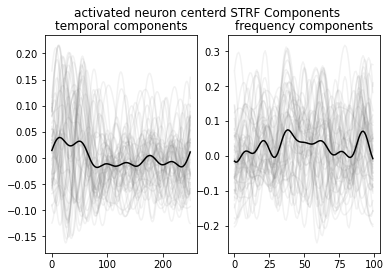

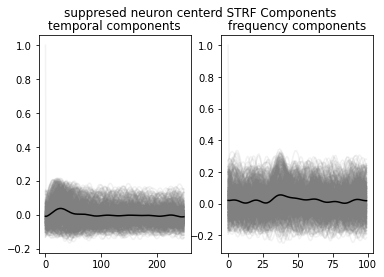

In [190]:
masks = [ff_act, ff_sup]
celltypes = ['activated', 'suppresed']

for mask, ctype in zip(masks, celltypes):

    tcomps = time_comp[mask]
    fcomps = freq_comp[mask]
    fig, axes = plot_components_with_mean(tcomps, fcomps)
    fig.suptitle(f'{ctype} neuron centerd STRF Components')